In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
seed = 80
test_size = 0.4
X_T_train, X_T_test = train_test_split(testset, test_size=test_size, random_state=seed)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
T_train_loader = torch.utils.data.DataLoader(X_T_train, batch_size=4,
                                         shuffle=False, num_workers=2)
T_test_loader = torch.utils.data.DataLoader(X_T_test, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


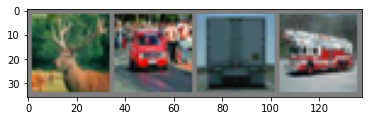

 deer   car truck truck


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim
import torch.nn.functional as F
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.393
[1,  4000] loss: 1.849
[1,  6000] loss: 1.684
[1,  8000] loss: 1.600
[1, 10000] loss: 1.540
[1, 12000] loss: 1.462
[2,  2000] loss: 1.415
[2,  4000] loss: 1.396
[2,  6000] loss: 1.368
[2,  8000] loss: 1.329
[2, 10000] loss: 1.294
[2, 12000] loss: 1.278
[3,  2000] loss: 1.211
[3,  4000] loss: 1.204
[3,  6000] loss: 1.197
[3,  8000] loss: 1.198
[3, 10000] loss: 1.202
[3, 12000] loss: 1.168
[4,  2000] loss: 1.086
[4,  4000] loss: 1.091
[4,  6000] loss: 1.117
[4,  8000] loss: 1.125
[4, 10000] loss: 1.088
[4, 12000] loss: 1.105
[5,  2000] loss: 1.017
[5,  4000] loss: 1.015
[5,  6000] loss: 1.047
[5,  8000] loss: 1.038
[5, 10000] loss: 1.011
[5, 12000] loss: 1.044
[6,  2000] loss: 0.928
[6,  4000] loss: 0.981
[6,  6000] loss: 0.973
[6,  8000] loss: 0.987
[6, 10000] loss: 0.988
[6, 12000] loss: 0.993
[7,  2000] loss: 0.882
[7,  4000] loss: 0.915
[7,  6000] loss: 0.929
[7,  8000] loss: 0.944
[7, 10000] loss: 0.947
[7, 12000] loss: 0.947
[8,  2000] loss: 0.851
[8,  4000] 

In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [8]:

class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, input):
        logits = self.model(input)
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader, loss_optim, training = True):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()
        mce_criterion = _MCELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        with torch.no_grad():
            for input, label in valid_loader:
                input = input.cuda()
                logits = self.model(input)
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece, before_avg_confidence_in_bin, before_accuracy_in_bin = ece_criterion(logits, labels)
        before_temperature_ece=before_temperature_ece.item()
        
        b1 = plt.bar( before_avg_confidence_in_bin, before_accuracy_in_bin, width = 0.05)
    
        print('Before temperature - NLL: %.3f, ECE/MCE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        if training :
          optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

          def eval():
              if loss_optim == "ECE" :
                loss,_,__ = ece_criterion(self.temperature_scale(logits), labels)
              if loss_optim == "MCE" :
                loss,_,__ = mce_criterion(self.temperature_scale(logits), labels)
              if loss_optim == "NLL" :
                loss= nll_criterion(self.temperature_scale(logits), labels)
              loss.backward()
              return loss
          optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        after_temperature_ece,  after_avg_confidence_in_bin, after_accuracy_in_bin = ece_criterion(self.temperature_scale(logits), labels)
        after_temperature_ece=after_temperature_ece.item()
        #print(after_avg_confidence_in_bin)
        #print(after_accuracy_in_bin)
        b2 = plt.bar( after_avg_confidence_in_bin, after_accuracy_in_bin, width = 0.05, color = 'green' , alpha = 0.5)
        plt.plot(np.arange(0,1+1/10,1/10),np.arange(0,1+1/10,1/10), color='red')
        plt.xlabel("proba")
        plt.ylabel("accuracy")
        plt.legend([b1, b2], ['avant temperature_scaling', 'après temperature_scaling'])
        if training :
          plt.title("Probabilité en fonction de l'accuracy, Entrainement, loss :  "+loss_optim)
        else :
          plt.title("Probabilité en fonction de l'accuracy, Validation, loss :  "+loss_optim)
        plt.show()
        print('Optimal temperature: %.3f' % self.temperature.item())
        print('After temperature - NLL: %.3f, ECE/MCE: %.3f' % (after_temperature_nll, after_temperature_ece))

        return self


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).

    The input to this loss is the logits of a model, NOT the softmax scores.

    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:

    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |

    We then return a weighted average of the gaps, based on the number
    of samples in each bin

    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        PROB = []
        ACCU = []
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                PROB +=[avg_confidence_in_bin.cpu().item()]
                ACCU +=[accuracy_in_bin.cpu().item()]
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return (ece, PROB, ACCU)



class _MCELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).

    The input to this loss is the logits of a model, NOT the softmax scores.

    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:

    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |

    We then return a weighted average of the gaps, based on the number
    of samples in each bin

    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_MCELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        PROB = []
        ACCU = []
        MCE = []
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                PROB +=[avg_confidence_in_bin.cpu().item()]
                ACCU +=[accuracy_in_bin.cpu().item()]
                MCE += [torch.abs(avg_confidence_in_bin - accuracy_in_bin)]

        return (max(MCE), PROB, ACCU)


Before temperature - NLL: 1.094, ECE/MCE: 0.082


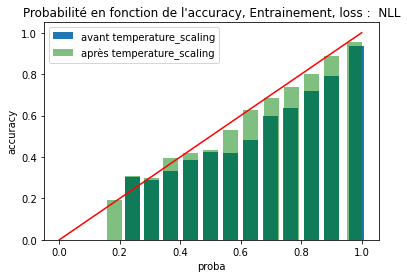

Optimal temperature: 1.281
After temperature - NLL: 1.053, ECE/MCE: 0.025
Before temperature - NLL: 1.086, ECE/MCE: 0.074


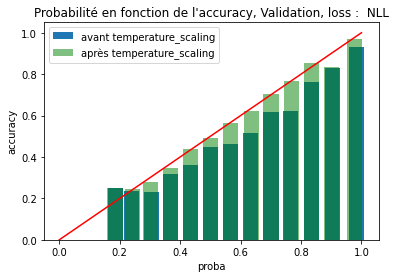

Optimal temperature: 1.281
After temperature - NLL: 1.048, ECE/MCE: 0.014


ModelWithTemperature(
  (model): Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=100, bias=True)
  )
)

In [14]:
orig_model = net # create an uncalibrated model somehow
valid_loader = trainloader # Create a DataLoader from the SAME VALIDATION SET used to train orig_model

scaled_model = ModelWithTemperature(orig_model)
scaled_model = scaled_model
scaled_model.set_temperature(T_train_loader, loss_optim = "NLL",training = True)
scaled_model.set_temperature(T_test_loader, loss_optim = "NLL",training = False)

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={10})'.format(self.mean, self.std)


In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    AddGaussianNoise(0., 10.)
])


In [ ]:
testset_noise = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader_noise = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


[0.18068814277648926, 0.24159987270832062, 0.3025731146335602, 0.36813393235206604, 0.435001015663147, 0.4992244839668274, 0.5656470656394958, 0.6325225234031677, 0.7007523775100708, 0.7672311663627625, 0.8353602290153503, 0.9023208022117615, 0.9804692268371582]
[0.0, 0.2432432472705841, 0.2922755777835846, 0.3375394344329834, 0.37791410088539124, 0.39277389645576477, 0.4596354365348816, 0.5428571701049805, 0.5994358658790588, 0.6128048300743103, 0.6916890144348145, 0.8092485666275024, 0.936589241027832]
Before temperature - NLL: 1.134, ECE: 0.078
[0.1291220486164093, 0.1829880326986313, 0.238960862159729, 0.3008897006511688, 0.36789414286613464, 0.4328952729701996, 0.498383104801178, 0.5667510032653809, 0.6327129006385803, 0.7002831697463989, 0.7659160494804382, 0.8338020443916321, 0.9018263220787048, 0.9765297770500183]
[0.0, 0.1666666716337204, 0.2512437701225281, 0.3391053378582001, 0.3846982717514038, 0.36807820200920105, 0.4883977770805359, 0.5492610931396484, 0.6037992238998413,

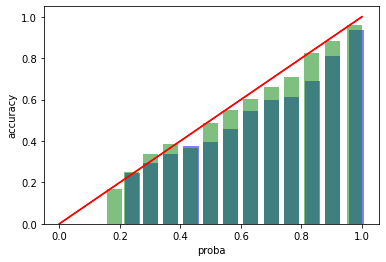

Optimal temperature: 1.258
After temperature - NLL: 1.095, ECE: 0.027


ModelWithTemperature(
  (model): Net(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=100, bias=True)
  )
)

In [ ]:
orig_model = net # create an uncalibrated model somehow
valid_loader = testloader_noise # Create a DataLoader from the SAME VALIDATION SET used to train orig_model

scaled_model = ModelWithTemperature(orig_model)
scaled_model = scaled_model
scaled_model.set_temperature(valid_loader)

In [ ]:
testloader